In [1]:
!pip install pymannkendall # just in case you don't have it

ERROR: Invalid requirement: '#'


In [28]:
import pandas as pd #importing libraries
import re
import matplotlib.pyplot as plt
import numpy as np
import requests
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pymannkendall as mk
import matplotlib.pyplot as plt
from scipy.stats import linregress

In [29]:
# Getting the data into a dataframe since it couldn't be downloaded locally easily

# URL of the data file
url = "https://berkeley-earth-temperature.s3.us-west-1.amazonaws.com/Global/Complete_TAVG_complete.txt"

# Download the file and save it
response = requests.get(url)
with open("Complete_TAVG_complete.txt", "wb") as file:
    file.write(response.content)

# Load the text file, specifying the header line
column_names = ["Year", "Month", "Anomaly", "Unc.", "Anomaly2", "Unc.2", "Anomaly3", "Unc.3", "Anomaly4", "Unc.4", "Anomaly5", "Unc.5"]
df = pd.read_csv("Complete_TAVG_complete.txt", delim_whitespace=True, comment='%', names=column_names, skiprows=1)

# Save to a CSV
df.to_csv("Global_Land_Surface_TAVG.csv", index=False)
print("Data has been saved to Global_Land_Surface_TAVG.csv")



Data has been saved to Global_Land_Surface_TAVG.csv


% This file contains a detailed summary of the land-surface average 
% results produced by the Berkeley Averaging method.  Temperatures are 
% in Celsius and reported as anomalies relative to the Jan 1951-Dec 1980 
% average.  Uncertainties represent the 95% confidence interval for 
% statistical and spatial undersampling effects.
% 
% The current dataset presented here is described as: 
% 
%   Estimated Global Land-Surface TAVG based on the Complete Berkeley Dataset

% This analysis was run on 12-Nov-2024 16:56:39
% 
% Results are based on 50738 time series 
%   with 21550254 data points
% 
% Estimated Jan 1951-Dec 1980 absolute temperature (C): 8.59 +/- 0.05
% 
% As Earth's land is not distributed symmetrically about the equator, there
% exists a mean seasonality to the global land-average.  

% 
% Estimated Jan 1951-Dec 1980 monthly absolute temperature:
%      Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov   Dec
%      2.57  3.19  5.29  8.29 11.27 13.41 14.29 13.83 12.05  9.20  6.06  3.61
% +/-  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.06  0.07  0.07
% 
% For each month, we report the estimated land-surface average for that 
% month and its uncertainty.  We also report the corresponding values for 
% year, five-year, ten-year, and twenty-year moving averages CENTERED about 
% that month (rounding down if the center is in between months).  For example, 
% the annual average from January to December 1950 is reported at June 1950. 

In [30]:
# Read in the CSV and aggregate to get rid of unnecessary columns and NAs

globalTemps = pd.read_csv('Global_Land_Surface_TAVG.csv')

In [31]:
globalTemps

,Year,Month,Anomaly,Unc.,Anomaly2,Unc.2,Anomaly3,Unc.3,Anomaly4,Unc.4,Anomaly5,Unc.5
0,1750,1,-0.599,2.908,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1750,2,-1.193,3.420,-0.883,0.895,NaN,NaN,NaN,NaN,NaN,NaN
2,1750,3,0.127,2.485,-0.915,0.915,NaN,NaN,NaN,NaN,NaN,NaN
3,1750,4,-0.197,1.981,-0.948,0.910,NaN,NaN,NaN,NaN,NaN,NaN
4,1750,5,-1.562,1.631,-1.261,0.912,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3293,2024,6,1.713,0.047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3294,2024,7,1.693,0.051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3295,2024,8,1.962,0.073,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3296,2024,9,1.741,0.067,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
globalTemps = globalTemps.drop(columns = ['Anomaly2', 'Unc.2', 'Anomaly3', 'Unc.3', 'Anomaly4', 'Unc.4', 'Anomaly5', 'Unc.5'])

In [33]:
globalTemps = globalTemps.dropna(subset=['Anomaly'])

In [34]:
globalTemps

,Year,Month,Anomaly,Unc.
0,1750,1,-0.599,2.908
1,1750,2,-1.193,3.420
2,1750,3,0.127,2.485
3,1750,4,-0.197,1.981
4,1750,5,-1.562,1.631
...,...,...,...,...
3293,2024,6,1.713,0.047
3294,2024,7,1.693,0.051
3295,2024,8,1.962,0.073
3296,2024,9,1.741,0.067


In [35]:
# Function to create a new column that has the degrees in celsius, 
# so we can have some sort of reference other then the anomaly 

# monthly absolute averages for the Berkeley data (in Celsius) (explained above in the Markdown Text)
monthly_averages = {
    1: 2.57,  # January
    2: 3.19,  # February
    3: 5.29,  # March
    4: 8.29,  # April
    5: 11.27, # May
    6: 13.41, # June
    7: 14.29, # July
    8: 13.83, # August
    9: 12.05, # September
    10: 9.20, # October
    11: 6.06, # November
    12: 3.61  # December
}

# calculate Celsius based on anomaly correlating to the month
def calculate_celsius(row):
    # get the monthly baseline average temperature
    base_temp = monthly_averages[row['Month']]
    # Calculate the actual temperature in Celsius by adding the anomaly
    celsius = base_temp + row['Anomaly']
    return round(celsius, 2)

# Apply the function & create Celsius column
globalTemps['Celsius'] = df.apply(calculate_celsius, axis=1)

In [36]:
globalTemps

,Year,Month,Anomaly,Unc.,Celsius
0,1750,1,-0.599,2.908,1.97
1,1750,2,-1.193,3.420,2.00
2,1750,3,0.127,2.485,5.42
3,1750,4,-0.197,1.981,8.09
4,1750,5,-1.562,1.631,9.71
...,...,...,...,...,...
3293,2024,6,1.713,0.047,15.12
3294,2024,7,1.693,0.051,15.98
3295,2024,8,1.962,0.073,15.79
3296,2024,9,1.741,0.067,13.79


In [37]:
newtemp = globalTemps[~globalTemps["Year"].between(1750, 1849)]

In [38]:
newtemp

,Year,Month,Anomaly,Unc.,Celsius
1200,1850,1,-1.753,1.312,0.82
1201,1850,2,-0.039,1.434,3.15
1202,1850,3,-0.408,1.094,4.88
1203,1850,4,-1.045,0.845,7.24
1204,1850,5,-1.291,0.565,9.98
...,...,...,...,...,...
3293,2024,6,1.713,0.047,15.12
3294,2024,7,1.693,0.051,15.98
3295,2024,8,1.962,0.073,15.79
3296,2024,9,1.741,0.067,13.79


In [39]:
# Another function, but for Fahrenheit

# Converting Celsius to Fahrenheit
def calculate_fahrenheit(row):
    fahrenheit = row['Celsius'] * 9 / 5 + 32
    return round(fahrenheit, 2)

# Apply the function to create a Fahrenheit column
globalTemps['Fahrenheit'] = globalTemps.apply(calculate_fahrenheit, axis=1)

In [40]:
globalTemps

,Year,Month,Anomaly,Unc.,Celsius,Fahrenheit
0,1750,1,-0.599,2.908,1.97,35.55
1,1750,2,-1.193,3.420,2.00,35.60
2,1750,3,0.127,2.485,5.42,41.76
3,1750,4,-0.197,1.981,8.09,46.56
4,1750,5,-1.562,1.631,9.71,49.48
...,...,...,...,...,...,...
3293,2024,6,1.713,0.047,15.12,59.22
3294,2024,7,1.693,0.051,15.98,60.76
3295,2024,8,1.962,0.073,15.79,60.42
3296,2024,9,1.741,0.067,13.79,56.82


In [41]:
 #Doing a couple test cases for random years

temps_2023 = globalTemps[globalTemps['Year'] == 2023]
print(temps_2023)

      Year  Month  Anomaly   Unc.  Celsius  Fahrenheit
3276  2023      1    1.230  0.061     3.80       38.84
3277  2023      2    1.428  0.080     4.62       40.32
3278  2023      3    1.941  0.067     7.23       45.01
3279  2023      4    1.227  0.094     9.52       49.14
3280  2023      5    1.043  0.077    12.31       54.16
3281  2023      6    1.315  0.107    14.72       58.50
3282  2023      7    1.502  0.065    15.79       60.42
3283  2023      8    1.646  0.092    15.48       59.86
3284  2023      9    2.151  0.090    14.20       57.56
3285  2023     10    2.092  0.097    11.29       52.32
3286  2023     11    2.073  0.150     8.13       46.63
3287  2023     12    2.003  0.137     5.61       42.10


In [42]:
temps_1895 = globalTemps[globalTemps['Year'] == 1895]
print(temps_1895)

      Year  Month  Anomaly   Unc.  Celsius  Fahrenheit
1740  1895      1   -1.158  0.443     1.41       34.54
1741  1895      2   -1.039  0.437     2.15       35.87
1742  1895      3   -0.563  0.317     4.73       40.51
1743  1895      4   -0.028  0.361     8.26       46.87
1744  1895      5   -0.282  0.358    10.99       51.78
1745  1895      6   -0.309  0.276    13.10       55.58
1746  1895      7   -0.115  0.340    14.18       57.52
1747  1895      8   -0.261  0.361    13.57       56.43
1748  1895      9   -0.221  0.296    11.83       53.29
1749  1895     10   -0.069  0.227     9.13       48.43
1750  1895     11   -0.202  0.308     5.86       42.55
1751  1895     12   -0.090  0.353     3.52       38.34


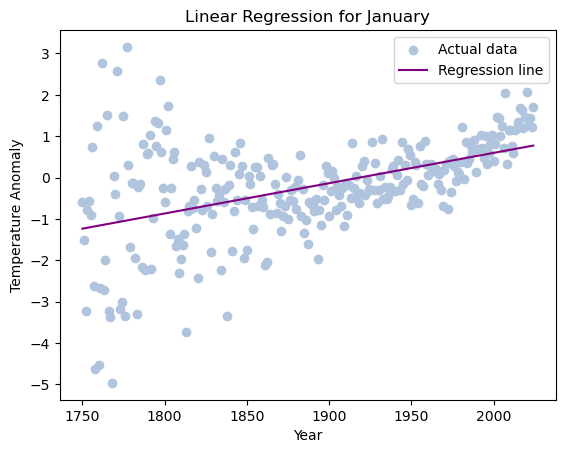

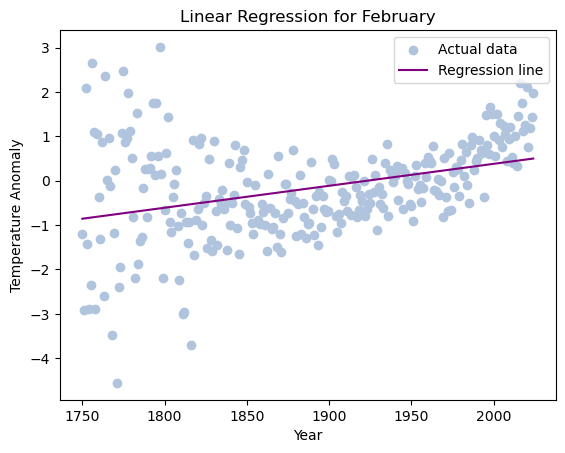

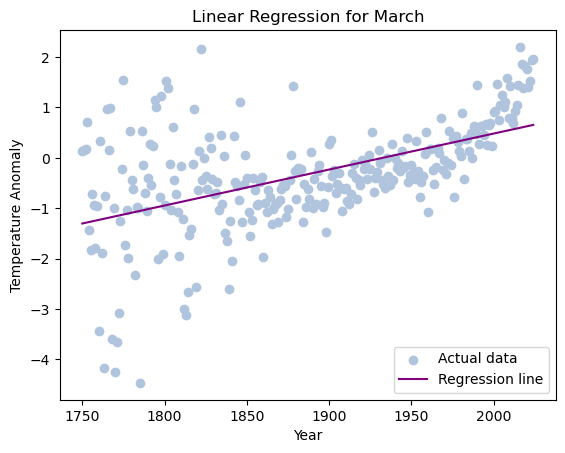

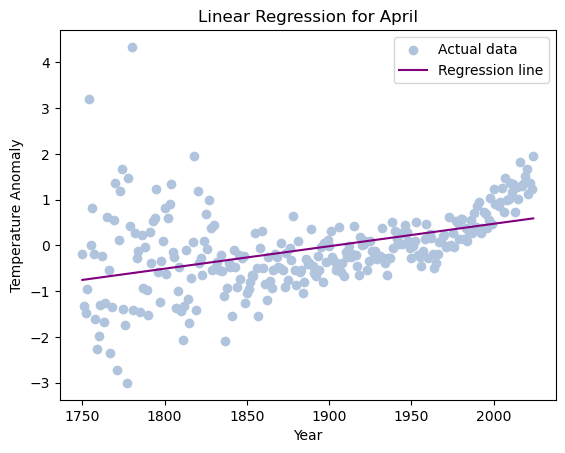

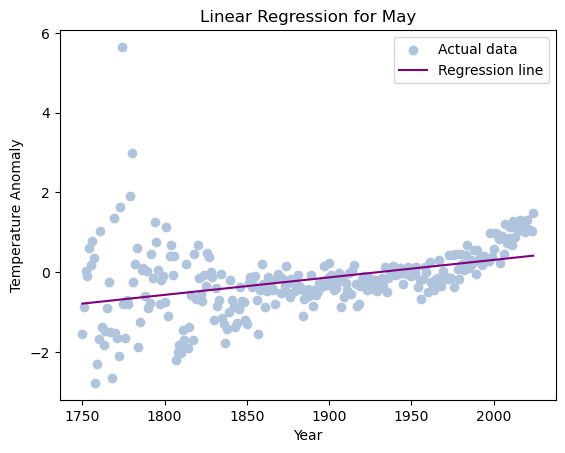

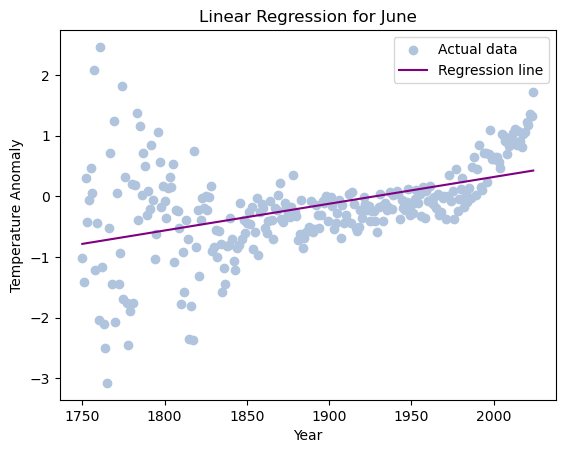

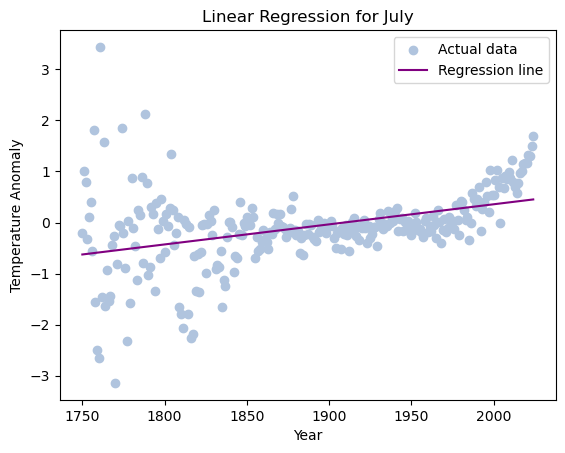

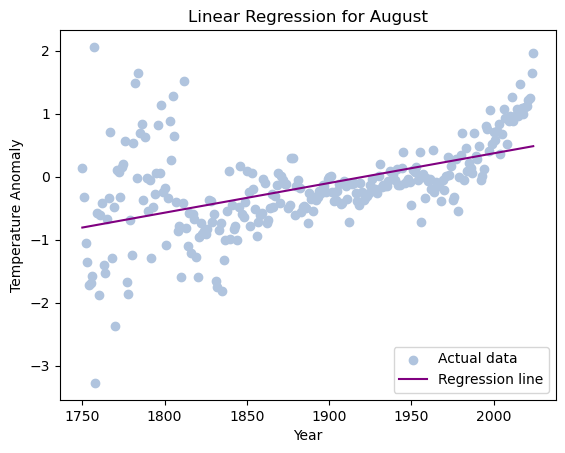

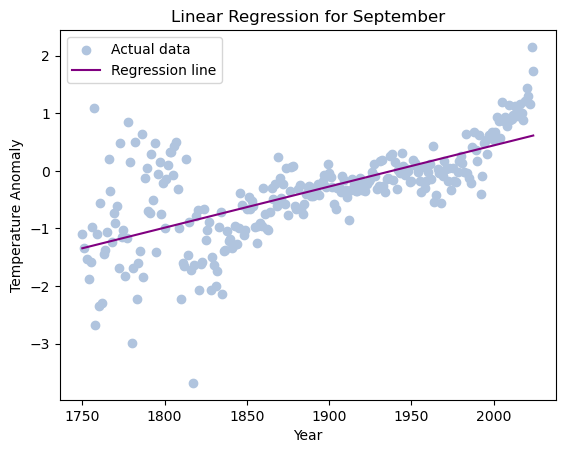

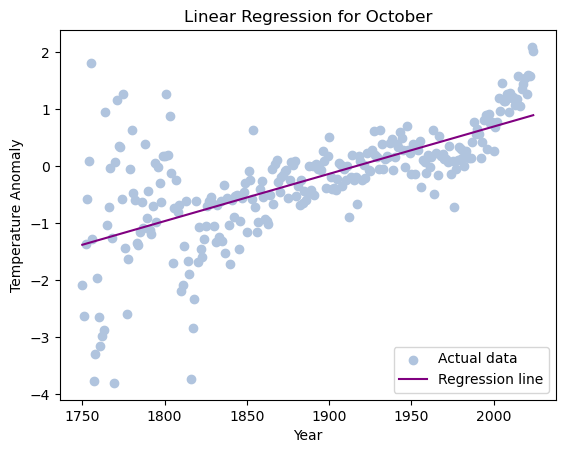

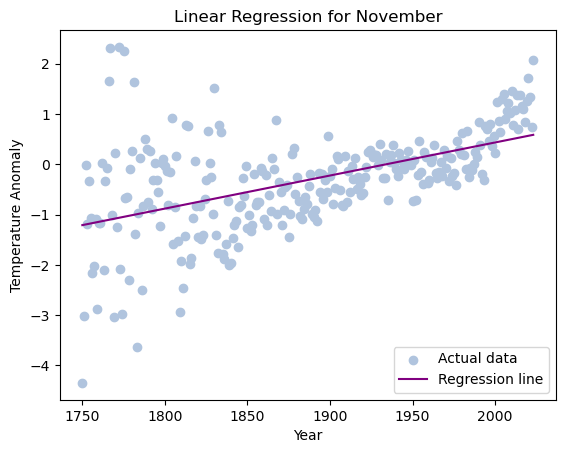

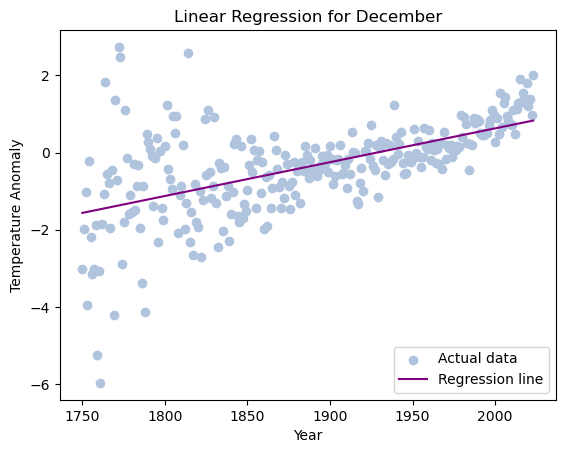

January:
  Slope: 0.007329490782147083
  Intercept: -14.06135637863882
  Mean Squared Error: 1.1600326779675265
  R-squared: 0.22591474459846073

February:
  Slope: 0.004950879086004444
  Intercept: -9.52017428983584
  Mean Squared Error: 1.0597962705728388
  R-squared: 0.12721234193176367

March:
  Slope: 0.007137056634257524
  Intercept: -13.792447687025765
  Mean Squared Error: 0.8405210027453901
  R-squared: 0.2763671356186381

April:
  Slope: 0.004911332044661147
  Intercept: -9.349574477366493
  Mean Squared Error: 0.644898070826355
  R-squared: 0.19075144883883266

May:
  Slope: 0.004392378754219439
  Intercept: -8.477065981939354
  Mean Squared Error: 0.6451943946328738
  R-squared: 0.15856519002482683

June:
  Slope: 0.0044127278497446696
  Intercept: -8.507741088831827
  Mean Squared Error: 0.4699172808925599
  R-squared: 0.20706581703423343

July:
  Slope: 0.003932162372695537
  Intercept: -7.506634033640115
  Mean Squared Error: 0.4809308788286253
  R-squared: 0.16847450594

In [43]:
# Performing 12 Linear Regression Models (one for each month) and also getting some basic stats on them

# store results for each month
results = {}

# List of month names
month_names = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"]

# Group the data by month
for month, group in globalTemps.groupby('Month'):
    # Extract the independent (Year) and dependent (Anomaly) variables
    X = group['Year'].values.reshape(-1, 1)
    y = group['Anomaly'].values

    # Perform the linear regression
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Store the results
    slope = model.coef_[0]
    intercept = model.intercept_
    mse = mean_squared_error(y, y_pred)
    r2 = r2_score(y, y_pred)
    
    results[month] = {
        'slope': slope,
        'intercept': intercept,
        'mse': mse,
        'r2': r2
    }

    # Plot the data and regression line for the month
    plt.figure()
    plt.scatter(X, y, color='lightsteelblue', label='Actual data')
    plt.plot(X, y_pred, color='purple', label='Regression line')
    plt.xlabel('Year')
    plt.ylabel('Temperature Anomaly')
    plt.title(f'Linear Regression for {month_names[month - 1]}')
    plt.legend()
    plt.show()

# Print the results for each month
for month, metrics in results.items():
    print(f"{month_names[month - 1]}:")
    print(f"  Slope: {metrics['slope']}")
    print(f"  Intercept: {metrics['intercept']}")
    print(f"  Mean Squared Error: {metrics['mse']}")
    print(f"  R-squared: {metrics['r2']}")
    print()


It's best to keep in mind that this data was gathered using an Anomaly method, which is based off a baseline temperature, so while it won't reflect the actual measured temperatures, it will accurately showcase the trend of temperature we've been experiencing the last few hundred years. 

To verify our data we will conduct Mann-Kendall tests, and then re-perform our methods on the yearly data.

In [44]:
# Perform a Mann-Kendall test for each month

month_results = {}
for month in range(1, 13):  # Loops through months (1 to 12)
    month_data = globalTemps[globalTemps['Month'] == month]['Anomaly']  # Filter the data for the month
    result = mk.original_test(month_data)  # Perform the Mann-Kendall test
    month_results[month] = result

# Display
for month, result in month_results.items():
    print(f"{month}: Trend={result.trend}, p-value={result.p}, S={result.s}")


1: Trend=increasing, p-value=0.0, S=14214.0
2: Trend=increasing, p-value=2.1449508835758024e-13, S=11188.0
3: Trend=increasing, p-value=0.0, S=15676.0
4: Trend=increasing, p-value=0.0, S=14912.0
5: Trend=increasing, p-value=0.0, S=14484.0
6: Trend=increasing, p-value=0.0, S=14271.0
7: Trend=increasing, p-value=0.0, S=12850.0
8: Trend=increasing, p-value=0.0, S=16552.0
9: Trend=increasing, p-value=0.0, S=20353.0
10: Trend=increasing, p-value=0.0, S=21211.0
11: Trend=increasing, p-value=0.0, S=16021.0
12: Trend=increasing, p-value=0.0, S=17932.0


In [45]:
# Now that we have monthly statistics, lets verify the significance using the yearly averages
# If you're curious, you can change "Anomaly" in the yearly_data variable to see how the P and S values change based
# on Celsius or Fahrenheit

# Sort the data by year, just in case any of the data is out of order
globalTemps = globalTemps.sort_values('Year')

# Group by 'Year' and calculate the average anomaly (for each year)
yearly_data = globalTemps.groupby('Year')['Anomaly'].mean()

# Perform the Mann-Kendall test for years
result = mk.original_test(yearly_data)

# Print the results
print(f"Trend: {result.trend}")
print(f"p-value: {result.p}")
print(f"S: {result.s}")

Trend: increasing
p-value: 0.0
S: 21954.0


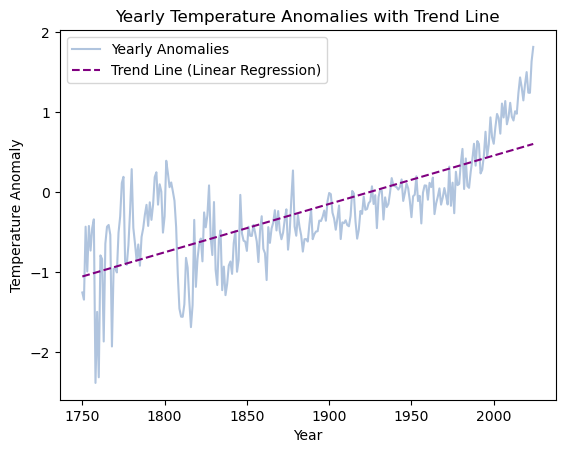

Slope: 0.006055633880713022
Intercept: -11.652187755495005


In [46]:
# To verify the Mann-Kendall test, perform another linear regression model on the yearly data, just like for the months
# This can also be done using Celsius and Fahrenheit, while it won't change the shape of the graph it'll 
# adjust the y axis to something that's more user friendly 

years = yearly_data.index
anomalies = yearly_data.values

# Perform the linear regression
slope, intercept, r_value, p_value, std_err = linregress(years, anomalies)

# Plotting the yearly data
plt.plot(years, anomalies, label='Yearly Anomalies', color='lightsteelblue')

# Add the regression trend line
plt.plot(years, slope * years + intercept, label='Trend Line (Linear Regression)', color='purple', linestyle='--')

# Create the plot
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.title('Yearly Temperature Anomalies with Trend Line')
plt.legend()

plt.show()

# Print the slope and intercept for the trend line
print(f"Slope: {slope}")
print(f"Intercept: {intercept}")

For this analysis, the P-values given are essentially p < 0.0001

In [47]:
# To verify the Mann-Kendall test, perform another linear regression model on the yearly data, just like for the months
# This can also be done using Celsius and Fahrenheit, while it won't change the shape of the graph it'll 
# adjust the y axis to something that's more user friendly 
yearly_data_mod = newtemp.groupby('Year')['Anomaly'].mean()
yearsmod = yearly_data_mod.index
anomaliesmod = yearly_data_mod.values

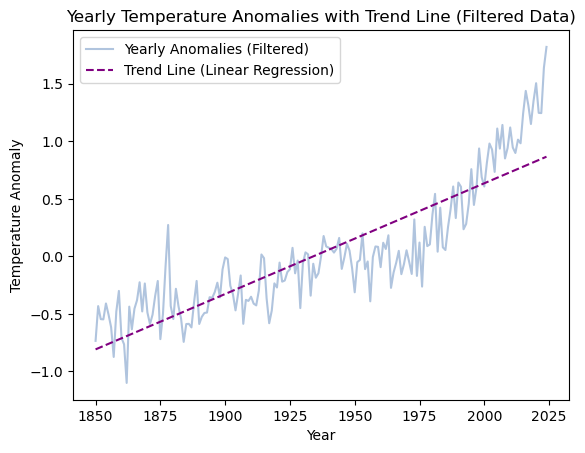

Slope (Filtered Data): 0.009619229399910438
Intercept (Filtered Data): -18.603675157150327


In [48]:
# Perform linear regression on the modified data (with years 1750-1850 removed)
slope_mod, intercept_mod, r_value_mod, p_value_mod, std_err_mod = linregress(yearsmod, anomaliesmod)

# Plot the modified data and trend line
plt.plot(yearsmod, anomaliesmod, label='Yearly Anomalies (Filtered)', color='lightsteelblue')
plt.plot(yearsmod, slope_mod * yearsmod + intercept_mod, label='Trend Line (Linear Regression)', color='purple', linestyle='--')

plt.xlabel('Year')
plt.ylabel('Temperature Anomaly')
plt.title('Yearly Temperature Anomalies with Trend Line (Filtered Data)')
plt.legend()
plt.show()

print(f"Slope (Filtered Data): {slope_mod}")
print(f"Intercept (Filtered Data): {intercept_mod}")
